In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/X_USDINR.csv')
X.drop('Unnamed: 0', axis=1, inplace=True)
X.head()

,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0.002366,0.003777,0.002111,0.000000,0.000000,0.000000,0.0,0.435743,0.428316,0.501290,0.000988,0.000382,0.026881
1,0.002990,0.003444,0.005988,0.000148,0.000077,0.000040,0.0,0.440006,0.429330,0.511641,0.000988,0.000382,0.026881
2,0.000000,0.009943,0.006819,0.000310,0.000162,0.000085,0.0,0.443880,0.431063,0.518980,0.000988,0.000382,0.026881
3,0.000808,0.004527,0.006440,0.000284,0.000152,0.000080,0.0,0.441573,0.431901,0.509839,0.000988,0.000382,0.026881
4,0.003394,0.004238,0.001931,0.000529,0.000282,0.000148,0.0,0.447507,0.433982,0.522539,0.000988,0.000382,0.026881


In [3]:
y = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/Y_USDINR.csv')
y.drop('Unnamed: 0', axis=1, inplace=True)
y.head()

,Closing_price
0,61.400
1,61.495
2,61.508
3,61.391
4,61.565


In [4]:
print(X.dtypes)
# print(y.dtype)

Deseasonalized_Day_high      float64
Deseasonalized_Day_low       float64
Deseasonalized_Open_price    float64
EMA_50                       float64
EMA_100                      float64
EMA_200                      float64
RSI                          float64
MACD                         float64
Signal_Line                  float64
MACD_Histogram               float64
SMA                          float64
Upper Band                   float64
Lower Band                   float64
dtype: object


In [5]:
print(y.columns)

Index(['Closing_price'], dtype='object')


In [6]:
import numpy as np

def evaluate_trading_metrics(y_true, y_pred, initial_capital=1000):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Ensure lengths match
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Compute directional accuracy
    true_diff = np.sign(np.diff(y_true))
    pred_diff = np.sign(np.diff(y_pred))
    correct = np.sum(true_diff == pred_diff)
    trading_accuracy = correct / len(true_diff) * 100

    # Simulate trading strategy
    capital = [initial_capital]
    for i in range(1, len(y_pred)):
        # If model says price will go up -> buy (position = +1)
        # If model says price will go down -> short (position = -1)
        position = 1 if y_pred[i] > y_pred[i - 1] else -1
        profit = position * (y_true[i] - y_true[i - 1])
        capital.append(capital[-1] + profit)

    capital = np.array(capital)
    returns = np.diff(capital) / capital[:-1]

    # ROI
    roi = (capital[-1] - initial_capital) / initial_capital * 100

    # Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) > 0 else 0

    # Max Drawdown
    peak = np.maximum.accumulate(capital)
    drawdown = (peak - capital) / peak
    max_drawdown = np.max(drawdown) * 100  # as a percentage

    return {
        "Trading Accuracy (%)": trading_accuracy,
        "ROI (%)": roi,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown
    }

In [ ]:
def directional_accuracy(actual, predicted):
    # Ensure 1D arrays
    actual = np.ravel(actual)
    predicted = np.ravel(predicted)

    # Compute direction change
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare directions
    correct_direction = np.sign(actual_diff) == np.sign(pred_diff)

    return np.mean(correct_direction) * 100

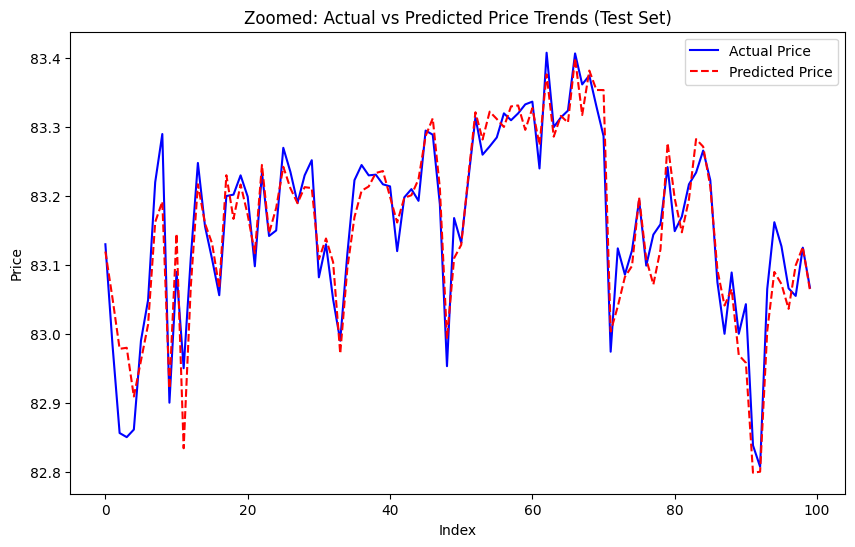

In [8]:
trading_metrics = None

def lr_model_sequential_split(X, y):
    # 85% train, 15% test
    total_size = len(X)
    train_end = int(total_size * 0.85)

    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[train_end:], y[train_end:]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    trading_metrics = evaluate_trading_metrics(y_test, y_pred)
    # Directional Accuracy
    dir_acc = directional_accuracy(y_test, y_pred)

    lr_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)",
            "Intercept",
            "Coefficients",
            "Directional Accuracy (%)"
        ],
        "Testing": [
            mae, 
            mse,
            mape * 100, 
            r2, 
            (1 - mape) * 100,
            model.intercept_,
            model.coef_,
            dir_acc
        ]
    }

    lr_metrics_df = pd.DataFrame(lr_metrics)

    # Zoomed plot
    zoom_start, zoom_end = 0, 100
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(zoom_end), y_test[zoom_start:zoom_end], label="Actual Price", color="blue")
    plt.plot(np.arange(zoom_end), y_pred[zoom_start:zoom_end], label="Predicted Price", color="red", linestyle="dashed")
    plt.xticks(ticks=np.arange(0, zoom_end + 1, 20))
    plt.title("Zoomed: Actual vs Predicted Price Trends (Test Set)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return lr_metrics_df, trading_metrics

lr_metrics_df, trading_metrics = lr_model_sequential_split(X,y)

In [9]:
total_size = len(X)

In [10]:
total_size

2710

In [11]:
lr_metrics_df

,Metric,Testing
0,Mean Absolute Error (MAE),0.035891
1,Mean Squared Error (MSE),0.002432
2,Mean Absolute Percentage Error (MAPE),0.042518
3,R-squared (R²),0.99838
4,Accuracy (1 - MAPE),99.957482
5,Intercept,[60.54290885186043]
6,Coefficients,"[[16.012089072029255, 13.887459317812949, -15...."
7,Directional Accuracy (%),80.788177


In [12]:
print(trading_metrics)

{'Trading Accuracy (%)': 80.78817733990148, 'ROI (%)': 2.8956999999999655, 'Sharpe Ratio': 0.7313626202026035, 'Max Drawdown (%)': 0.018353746995537948}


In [13]:
y = y['Closing_price']

Walk Forward Validation

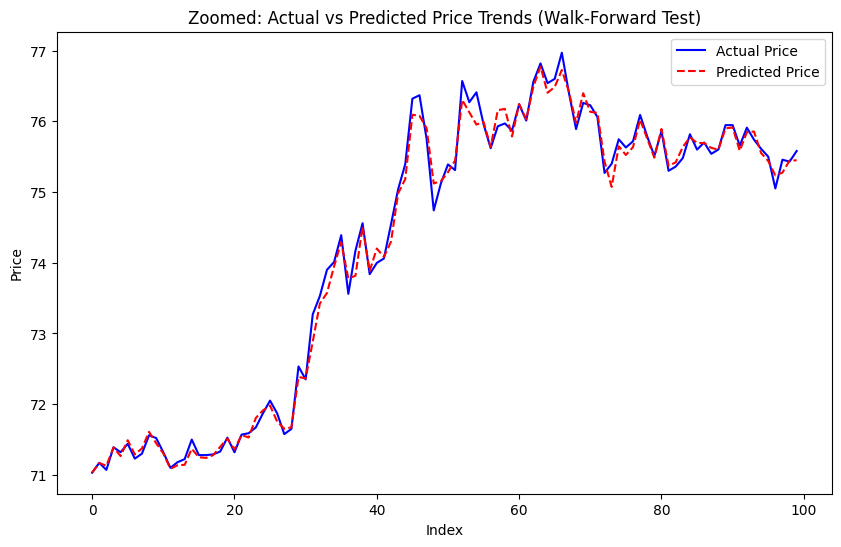

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def lr_model_walk_forward(X, y, initial_train_size=0.5, test_window=1):
    total_size = len(X)
    train_end = int(total_size * initial_train_size)

    predictions = []
    actuals = []

    for i in range(train_end, total_size - test_window + 1):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + test_window], y[i:i + test_window]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.extend(y_pred)
        actuals.extend(y_test)

    # Convert to arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Metrics
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    wf_trading_metrics = evaluate_trading_metrics(actuals, predictions)
    # Directional Accuracy
    dir_acc = directional_accuracy(actuals, predictions)
    lr_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)",
            "Directional Accuracy (%)"
        ],
        "Walk-Forward Testing": [
            mae, 
            mse,
            mape * 100, 
            r2, 
            (1 - mape) * 100,
            dir_acc
        ]
    }

    lr_metrics_df = pd.DataFrame(lr_metrics)

    # Plot actual vs predicted (zoomed)
    zoom_end = min(100, len(actuals))
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(zoom_end), actuals[:zoom_end], label="Actual Price", color="blue")
    plt.plot(np.arange(zoom_end), predictions[:zoom_end], label="Predicted Price", color="red", linestyle="dashed")
    plt.xticks(ticks=np.arange(0, zoom_end + 1, 20))
    plt.title("Zoomed: Actual vs Predicted Price Trends (Walk-Forward Test)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return lr_metrics_df, wf_trading_metrics

# Call the function
lr_metrics_df_wlkFrwdVal, wf_trading_metrics = lr_model_walk_forward(X, y)

In [15]:
lr_metrics_df_wlkFrwdVal

,Metric,Walk-Forward Testing
0,Mean Absolute Error (MAE),0.061357
1,Mean Squared Error (MSE),0.007404
2,Mean Absolute Percentage Error (MAPE),0.078794
3,R-squared (R²),0.999638
4,Accuracy (1 - MAPE),99.921206
5,Directional Accuracy (%),82.422452


In [16]:
wf_trading_metrics

{'Trading Accuracy (%)': 82.42245199409159,
 'ROI (%)': 17.800199999999382,
 'Sharpe Ratio': 0.7476489241456277,
 'Max Drawdown (%)': 0.05808310018055295}

# Rolling Window Walk Forward

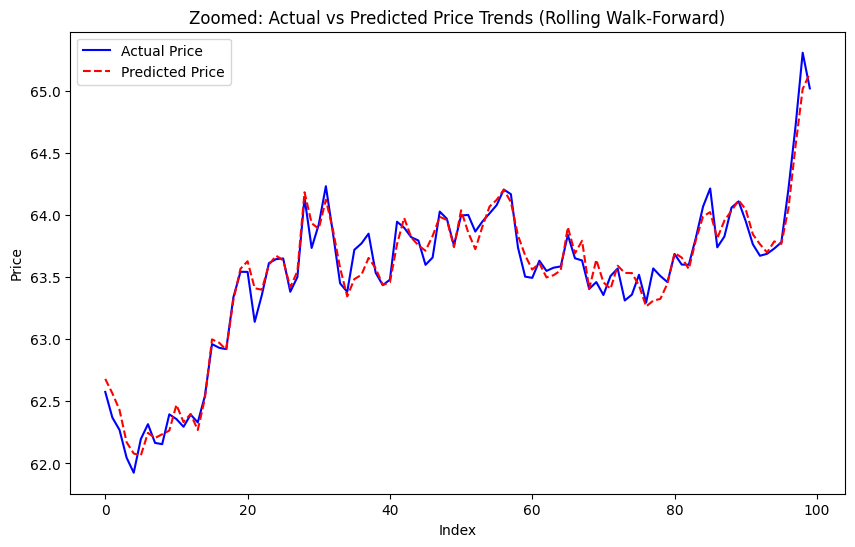

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

wfrl_trading_metrics = None

def lr_model_walk_forward_rolling(X, y, train_window=100, test_window=1):
    total_size = len(X)
    predictions = []
    actuals = []

    for start in range(0, total_size - train_window - test_window + 1):
        train_start = start
        train_end = start + train_window
        test_end = train_end + test_window

        X_train, y_train = X[train_start:train_end], y[train_start:train_end]
        X_test, y_test = X[train_end:test_end], y[train_end:test_end]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.extend(y_pred.flatten())  # ensure it's a 1D list
        actuals.extend(y_test)

    # Convert to arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Metrics
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    wfrl_trading_metrics = evaluate_trading_metrics(actuals, predictions)
    # Directional Accuracy
    dir_acc = directional_accuracy(actuals, predictions)

    lr_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)",
            "Directional Accuracy (%)"
        ],
        "Rolling Walk-Forward Testing": [
            mae, 
            mse,
            mape * 100, 
            r2, 
            (1 - mape) * 100,
            dir_acc
        ]
    }

    lr_metrics_df = pd.DataFrame(lr_metrics)

    # Plot (Zoomed)
    zoom_end = min(100, len(actuals))
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(zoom_end), actuals[:zoom_end], label="Actual Price", color="blue")
    plt.plot(np.arange(zoom_end), predictions[:zoom_end], label="Predicted Price", color="red", linestyle="dashed")
    plt.xticks(ticks=np.arange(0, zoom_end + 1, 20))
    plt.title("Zoomed: Actual vs Predicted Price Trends (Rolling Walk-Forward)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return lr_metrics_df, wfrl_trading_metrics

lr_metrics_df_rollingWF, wfrl_trading_metrics = lr_model_walk_forward_rolling(X, y, train_window=100, test_window=1)

In [18]:
lr_metrics_df_rollingWF

,Metric,Rolling Walk-Forward Testing
0,Mean Absolute Error (MAE),0.075868
1,Mean Squared Error (MSE),0.010531
2,Mean Absolute Percentage Error (MAPE),0.104808
3,R-squared (R²),0.999782
4,Accuracy (1 - MAPE),99.895192
5,Directional Accuracy (%),80.950556


In [19]:
wfrl_trading_metrics

{'Trading Accuracy (%)': 80.95055576849367,
 'ROI (%)': 35.96699999999981,
 'Sharpe Ratio': 0.7658541227504334,
 'Max Drawdown (%)': 0.050988167401667936}

Hold out Implementation

In [20]:
ho_trading_metrics = None

In [21]:
def split_holdout(X, y, holdout_ratio=0.1):
    total_len = len(X)
    split_idx = int(total_len * (1 - holdout_ratio))

    X_train, X_holdout = X[:split_idx], X[split_idx:]
    y_train, y_holdout = y[:split_idx], y[split_idx:]

    return X_train, y_train, X_holdout, y_holdout

In [22]:
from sklearn.linear_model import LinearRegression

X_train, y_train, X_holdout, y_holdout = split_holdout(X, y)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [23]:
y_pred_holdout = model.predict(X_holdout)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

mae = mean_absolute_error(y_holdout, y_pred_holdout)
mse = mean_squared_error(y_holdout, y_pred_holdout)
mape = mean_absolute_percentage_error(y_holdout, y_pred_holdout)
r2 = r2_score(y_holdout, y_pred_holdout)

ho_y_test = y_holdout
ho_y_pred = y_pred_holdout

ho_trading_metrics = evaluate_trading_metrics(y_holdout, y_pred_holdout)

# Directional Accuracy
dir_acc = directional_accuracy(y_holdout, y_pred_holdout)

print("Hold-Out Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"R²:   {r2:.4f}")
print(f"Accuracy: {(1 - mape) * 100:.2f}%")
print(f"Directional Accuracy: {dir_acc:.2f}%")

Hold-Out Metrics:
MAE:  0.0390
MSE:  0.0029
MAPE: 0.05%
R²:   0.9982
Accuracy: 99.95%
Directional Accuracy: 81.11%


In [25]:
ho_trading_metrics

{'Trading Accuracy (%)': 81.11111111111111,
 'ROI (%)': 2.0719999999999574,
 'Sharpe Ratio': 0.7124798378204474,
 'Max Drawdown (%)': 0.018502534748841695}

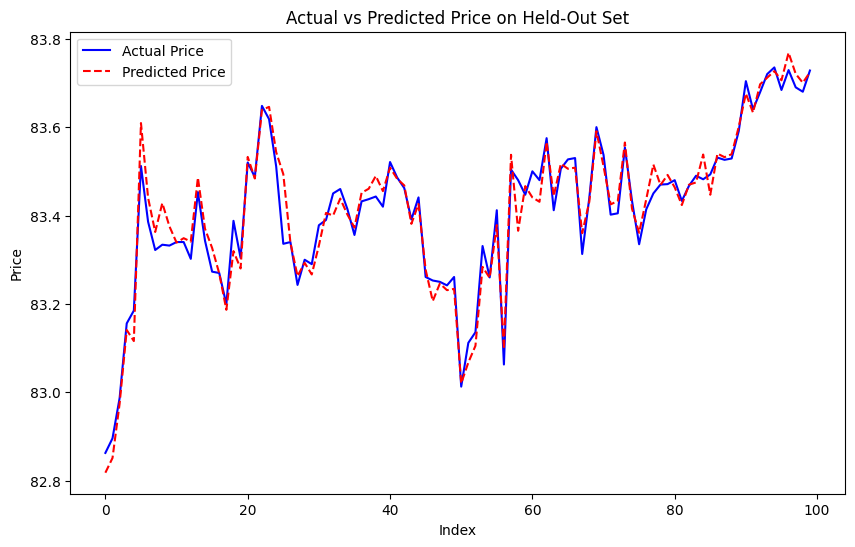

In [26]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
zoom_end = min(100, len(y_holdout))
plt.plot(np.arange(zoom_end), y_holdout[:zoom_end], label="Actual Price", color="blue")
plt.plot(np.arange(zoom_end), y_pred_holdout[:zoom_end], label="Predicted Price", color="red", linestyle="dashed")
plt.title("Actual vs Predicted Price on Held-Out Set")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

1. Sharpe Ratio
→ To evaluate how well your model balances reward vs risk. Especially useful if you simulate returns across time.

2. ROI (Return on Investment)
→ Shows whether a trading strategy built on your model is profitable overall.

3. Maximum Drawdown
→ Tells you how risky your trading signals are — what’s the worst-case loss if someone followed your model.

4. Trading Accuracy
→ A simple and essential metric: how often your model gets the direction right.

Sharpe Ratio answers: “Is this risk-efficient?”

ROI answers: “Did we grow our investment?”

Drawdown answers: “How badly could this strategy hurt me?”

Trading accuracy answers: “Did it guess up/down correctly?”

# SHAP on Rolling Window
Rolling window = dynamic behavior

The model is retrained and tested on different slices of time-series data.

This simulates real-world deployment and captures temporal changes in data patterns.

SHAP = feature-level transparency

SHAP explains how much each feature contributes to every individual prediction.

By applying SHAP across each window, you can track:

Feature importance drift over time

If the model starts relying on unstable or spurious patterns

If certain features become more or less relevant as market conditions change

Helps identify issues or trust your model

For example, if SHAP shows a feature with rising importance before performance drops, that may indicate a regime shift or data instability.

In [27]:
import shap

def lr_model_walk_forward_rolling(X, y, train_window=100, test_window=1):
    total_size = len(X)
    predictions = []
    actuals = []

    shap_values_list = []
    shap_expected_values = []
    shap_input_samples = []

    for start in range(0, total_size - train_window - test_window + 1):
        train_start = start
        train_end = start + train_window
        test_end = train_end + test_window

        X_train, y_train = X[train_start:train_end], y[train_start:train_end]
        X_test, y_test = X[train_end:test_end], y[train_end:test_end]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        predictions.extend(y_pred.flatten())  # ensure it's a 1D list
        actuals.extend(y_test)

        # === SHAP per window ===
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)

        shap_values_list.append(shap_values.values)
        shap_expected_values.append(shap_values.base_values)
        shap_input_samples.append(X_test)

    # Convert to arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Metrics
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    wfrl_trading_metrics = evaluate_trading_metrics(actuals, predictions)
    # Directional Accuracy
    dir_acc = directional_accuracy(actuals, predictions)
    lr_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)", 
            "Accuracy (1 - MAPE)",
            "Directional Accuracy (%)"
        ],
        "Rolling Walk-Forward Testing": [
            mae, 
            mse,
            mape * 100, 
            r2, 
            (1 - mape) * 100,
            dir_acc
        ]
    }

    lr_metrics_df = pd.DataFrame(lr_metrics)

    # Plot (Zoomed)
    zoom_end = min(100, len(actuals))
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(zoom_end), actuals[:zoom_end], label="Actual Price", color="blue")
    plt.plot(np.arange(zoom_end), predictions[:zoom_end], label="Predicted Price", color="red", linestyle="dashed")
    plt.xticks(ticks=np.arange(0, zoom_end + 1, 20))
    plt.title("Zoomed: Actual vs Predicted Price Trends (Rolling Walk-Forward)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # OPTIONAL: SHAP summary plot for a subset of rolling windows
    if len(shap_values_list) >= 10:
        sample_index = -1  # last rolling window
        shap.summary_plot(
            shap_values_list[sample_index], 
            pd.DataFrame(shap_input_samples[sample_index], columns=X.columns),
            show=True
        )

    return lr_metrics_df, wfrl_trading_metrics

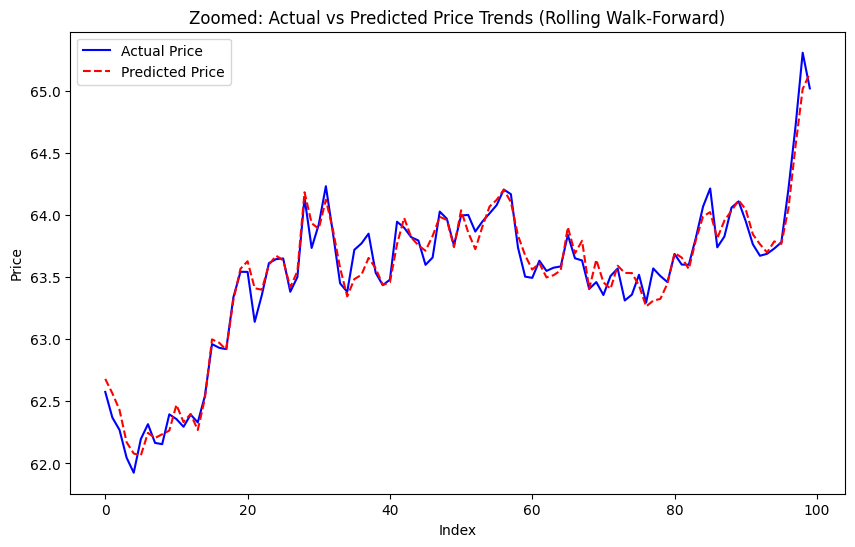

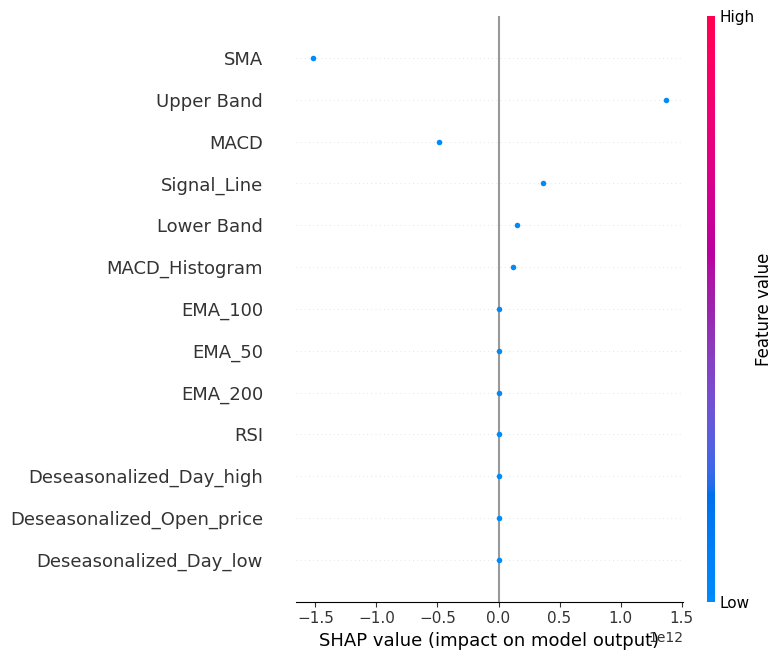

In [28]:
lr_metrics_df_rollingWF, wfrl_trading_metrics = lr_model_walk_forward_rolling(
    X=X, 
    y=y, 
    train_window=100, 
    test_window=1
)

In [29]:
lr_metrics_df_rollingWF

,Metric,Rolling Walk-Forward Testing
0,Mean Absolute Error (MAE),0.075868
1,Mean Squared Error (MSE),0.010531
2,Mean Absolute Percentage Error (MAPE),0.104808
3,R-squared (R²),0.999782
4,Accuracy (1 - MAPE),99.895192
5,Directional Accuracy (%),80.950556
